# Logistic Regression (Variance Threshold) Final Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [3]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [4]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [5]:
y_train = train['rating_category']
y_test = test['rating_category']

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV

# Define the pipeline
logistic_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', LogisticRegression(max_iter=1000))
])

In [8]:
# Define parameter grid
param_grid_logreg = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__C': [0.1, 1],
    'classification__solver': ['saga'],
    'classification__penalty': ['l1', 'elasticnet'],
    'classification__l1_ratio': [0.5]
}

In [9]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(logistic_pipeline, param_grid_logreg, cv=5, n_jobs=-1, verbose=3, error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'classification__C': [0.1, 1],
                         'classification__l1_ratio': [0.5],
                         'classification__penalty': ['l1', 'elasticnet'],
                         'classification__solver': ['saga'],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=3)

In [10]:
import joblib

# Save the trained model
joblib.dump(grid_search.best_estimator_, '/content/drive/MyDrive/data/logreg_vt_model.pkl')

['/content/drive/MyDrive/data/logreg_vt_model.pkl']

In [11]:
from sklearn.preprocessing import label_binarize

# Get class labels from the trained model
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

# Binarize y_test
y_test_binarized = label_binarize(y_test, classes=class_labels)

# Predict on the test set
y_pred_logreg_vt = grid_search.best_estimator_.predict(X_test)
y_score_logreg_vt = grid_search.best_estimator_.predict_proba(X_test)

In [12]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set (useful for ROC curve, etc.)
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score (mean cross-validated score of the best_estimator)
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results


In [13]:
# Execute the function and store the results
results_logreg = post_grid_search_analysis(grid_search, X_test, y_test)

# Print the results
print(f"Best Log Reg (VT) Parameters: {results_logreg['Best Parameters']}")
print(f"Best Log Reg (VT) Score: {results_logreg['Best Score']}")
print(f"Log Reg Test (VT) Accuracy: {results_logreg['Test Accuracy']}")

Best Log Reg (VT) Parameters: {'classification__C': 1, 'classification__l1_ratio': 0.5, 'classification__penalty': 'elasticnet', 'classification__solver': 'saga', 'variance_threshold__threshold': 0.0005}
Best Log Reg (VT) Score: 0.6276268412438625
Log Reg Test (VT) Accuracy: 0.639601885804086


In [19]:
# Get the logistic regression model from the best_estimator_ attribute
logistic_model = grid_search.best_estimator_.named_steps['classification']

# Get the variance threshold model from the best_estimator_ attribute
variance_threshold_model = grid_search.best_estimator_.named_steps['variance_threshold']

# Get the mask of kept features
mask = variance_threshold_model.get_support()

# Get the names of the features that were kept
feature_names = X_train.columns[mask]

# Get the classes from the logistic regression model
classes = logistic_model.classes_

# Get the coefficients
coefficients = logistic_model.coef_

# Create a DataFrame for the coefficients
coef_df_vt = pd.DataFrame(coefficients, columns=feature_names)

# Label the rows with the class names
coef_df_vt['class'] = classes

# Set 'class' as the index
coef_df_vt.set_index('class', inplace=True)

# Sort the DataFrame
sorted_coef_vt = coef_df_vt.T.sort_values(by=classes[0], ascending=False)

In [21]:
sorted_coef_vt.head(20)

class,Average,Excellent,Good,Poor
unigram_good,1.359727,-2.424082,-0.151799,1.216152
budget,1.343083,-2.345678,-0.484332,1.486933
unigram_lot,0.967215,-0.955232,-0.209650,0.197637
unigram_marry,0.904540,-0.817299,-0.186840,0.100716
unigram_want,0.825421,-0.943835,-0.068470,0.186133
bigram_waste time,0.792586,-2.386443,-0.927928,2.522038
unigram_little,0.789692,-0.539507,0.419117,-0.669333
bigram_negative review,0.760309,-1.006905,-0.635606,0.882203
unigram_gore,0.730878,-0.277172,-0.028424,-0.258684
bigram_lead man,0.726922,-0.251298,-0.471580,0.000000


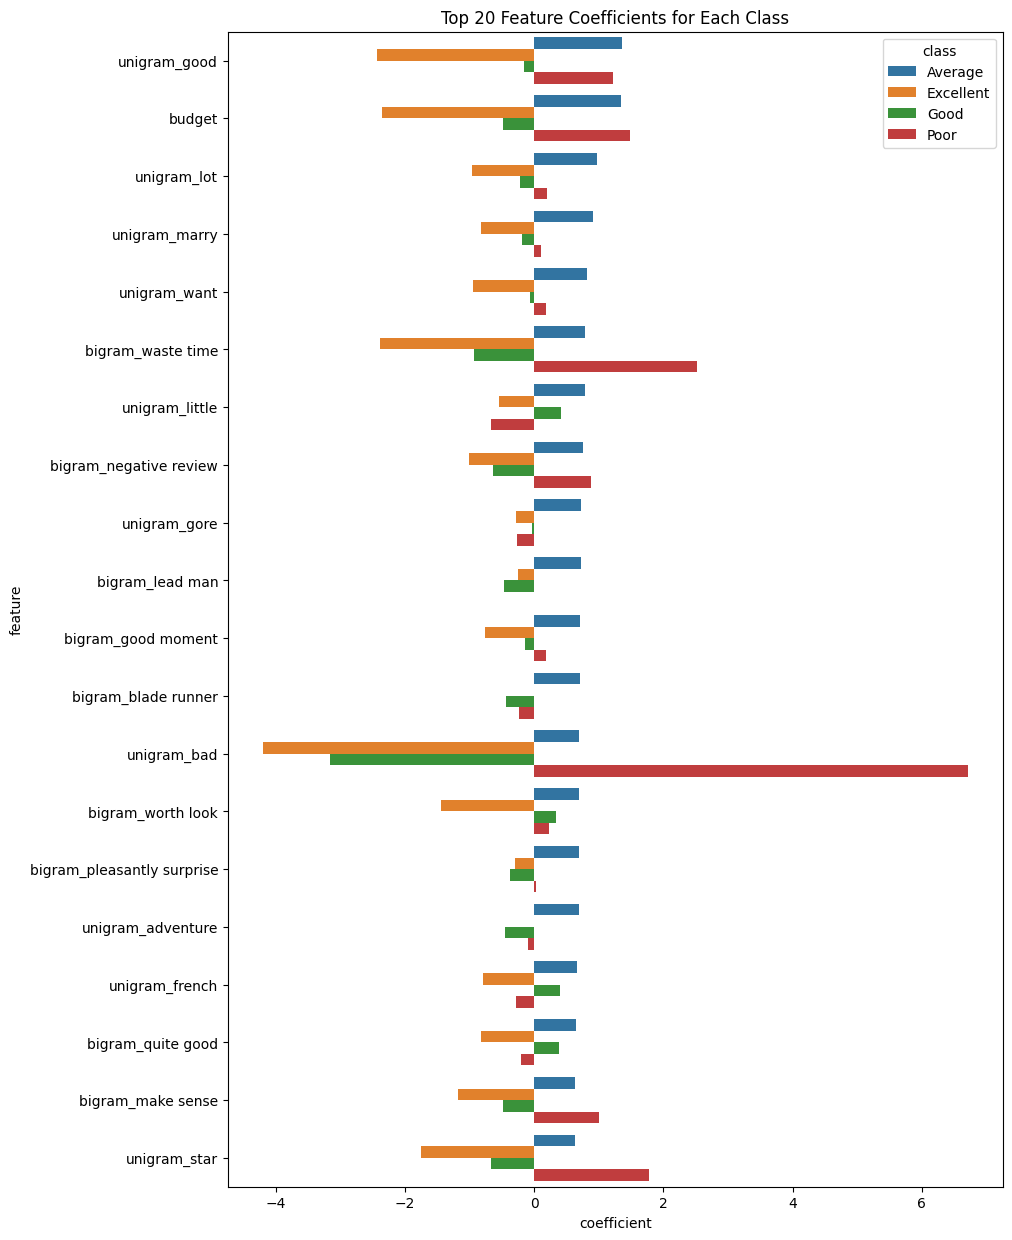

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# let's consider only the first 20 features for better visibility
top_n = 20
sorted_coef_top_n = sorted_coef_vt.head(top_n).reset_index()
sorted_coef_top_n = sorted_coef_top_n.rename(columns={'index': 'feature'})
melted_coef = pd.melt(sorted_coef_top_n, id_vars='feature', var_name='class', value_name='coefficient')

# Plotting
plt.figure(figsize=(10, 15))
sns.barplot(x='coefficient', y='feature', hue='class', data=melted_coef)
plt.title('Top {} Feature Coefficients for Each Class'.format(top_n))
plt.show()

In [23]:
# Getting class labels
class_labels = grid_search.best_estimator_.named_steps['classification'].classes_

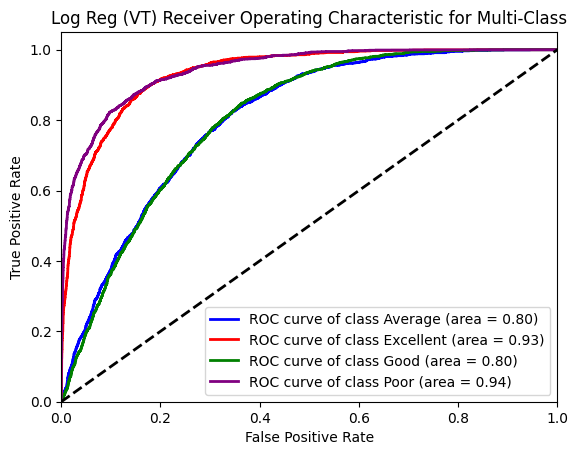

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Use the y_test_binarized we created earlier
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score_logreg_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg (VT) Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [25]:
from sklearn.metrics import classification_report

# Generate classification report
logreg_vt_report = classification_report(y_test, y_pred_logreg_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
logreg_vt_report_df = pd.DataFrame(logreg_vt_report).transpose()

In [26]:
logreg_vt_report_df

,precision,recall,f1-score,support
Average,0.527382,0.507109,0.517047,1899.000000
Excellent,0.734706,0.729285,0.731985,1762.000000
Good,0.532908,0.547980,0.540339,1980.000000
Poor,0.765926,0.777444,0.771642,1995.000000
accuracy,0.639602,0.639602,0.639602,0.639602
macro avg,0.640230,0.640454,0.640253,7636.000000
weighted avg,0.638977,0.639602,0.639199,7636.000000


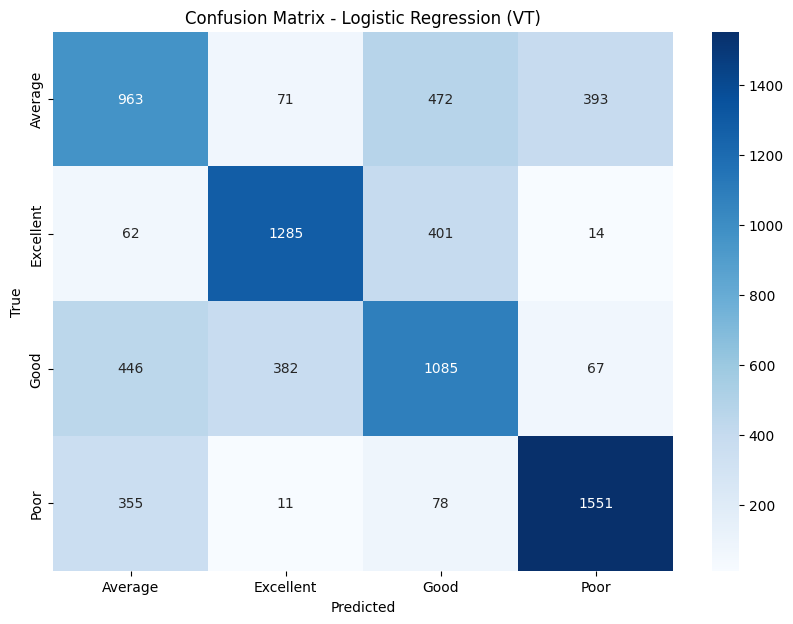

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for your test and predicted labels
cm_logreg_vt = confusion_matrix(y_test, y_pred_logreg_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_logreg_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Logistic Regression (VT)')
plt.show()